In [1]:
%pip install -q iterative-stratification

In [87]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 8.1 MB/s eta 0:00:00


In [2]:
import json, math, os, re, ast, io, zipfile
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    hamming_loss, f1_score, precision_score, recall_score, precision_recall_fscore_support,
)
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [3]:
try:
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
    print("MultilabelStratifiedKFold ready")
    USE_MLSK = True
except ModuleNotFoundError as e:
    print("iterstrat not found in this runtime. Installing an alternative…", e)
    %pip install -q scikit-multilearn
    from skmultilearn.model_selection import IterativeStratification
    USE_MLSK = False

MultilabelStratifiedKFold ready


In [4]:
RANDOM_STATE = 44
np.random.seed(RANDOM_STATE)

In [84]:
#can import through drive
#from pathlib import Path
src_path = Path("/content/steam_app_data.xlsx")
data = pd.read_excel(src_path)
#or file upload
#from google.colab import files
#uploaded = files.upload()
# Replace with your uploaded file name (check after upload)
#df = pd.read_excel("AppDataClean.xlsx")

In [ ]:
import re, ast
from html import unescape

IN_PATH = "steam_app_data.xlsx"
OUT_XLS = "steam_app_data_clean.xlsx"

def snake(s: str) -> str:
    s = re.sub(r"[^\w]+", "_", str(s).strip().lower())
    return re.sub(r"_{2,}", "_", s).strip("_")

def clean_text_series(s: pd.Series) -> pd.Series:
    s2 = s.copy()
    mask = s2.notna() & s2.map(lambda x: isinstance(x, str))
    s2.loc[mask] = s2.loc[mask].map(unescape)
    s2.loc[mask] = s2.loc[mask].str.replace("<br />", "\n", regex=False)
    s2.loc[mask] = s2.loc[mask].str.replace(r"<[^>]+>", "", regex=True)
    s2.loc[mask] = s2.loc[mask].str.strip()
    s2 = s2.mask(s2 == "")
    return s2

def safe_literal_eval(x):
    if not isinstance(x, str):
        return x
    x = x.strip()
    if not x or x[0] not in "[{":
        return x
    try:
        return ast.literal_eval(x)
    except Exception:
        return x

def extract_text_list(val, keys=("description","name","english","type","id","descriptionid")):
    if isinstance(val, list):
        parts = []
        for item in val:
            if isinstance(item, dict):
                taken = False
                for k in keys:
                    if k in item and isinstance(item[k], (str,int,float,bool)):
                        parts.append(str(item[k])); taken = True; break
                if not taken:
                    parts.append(str(item))
            else:
                parts.append(str(item))
        seen, out = set(), []
        for p in parts:
            if p not in seen:
                seen.add(p); out.append(p)
        return out or np.nan
    if isinstance(val, dict):
        out = [str(v) for v in val.values() if isinstance(v, (str,int,float,bool))]
        return out or [str(val)]
    if pd.isna(val) or val == "":
        return np.nan
    return [str(val)]

def main():
    data = pd.read_excel(IN_PATH)

    unnamed = [c for c in data.columns if str(c).lower().startswith("unnamed")]
    data = data.drop(columns=unnamed, errors="ignore")
    miss = data.isna().mean()
    data = data.drop(columns=miss[miss > 0.95].index.tolist(), errors="ignore")

    data.columns = [snake(c) for c in data.columns]

    for col in data.select_dtypes(include="object").columns:
        data[col] = clean_text_series(data[col])

    key_cols = [c for c in ["steam_appid", "name"] if c in data.columns]
    if key_cols:
        data = data.dropna(subset=key_cols)
        data = data.drop_duplicates(subset=key_cols, keep="first")
        if "name" in data.columns:
            data = data[data["name"].astype(str).str.len() > 0]

    bool_cols = [c for c in ["is_free","windows","mac","linux"] if c in data.columns]
    for c in bool_cols:
        data[c] = data[c].map(
            lambda v: True if str(v).lower() in {"true","1","yes"} else
                      False if str(v).lower() in {"false","0","no"} else np.nan
        )

    num_cols = [c for c in [
        "required_age","metacritic","positive","negative","recommendations",
        "price_overview_initial","price_overview_final"
    ] if c in data.columns]
    for c in num_cols:
        data[c] = pd.to_numeric(data[c], errors="coerce")

    date_cols = [c for c in [
        "release_date","required_age_since","price_overview_discount_expiration"
    ] if c in data.columns]
    for c in date_cols:
        data[c] = pd.to_datetime(data[c], errors="coerce")

    json_like = []
    for col in data.columns:
        if data[col].dtype == "object":
            sample = data[col].dropna().astype(str).head(25)
            if len(sample) and (sample.str.match(r"^\s*[\[{]").mean() > 0.5):
                json_like.append(col)
    for col in json_like:
        data[col] = data[col].map(safe_literal_eval)

    to_norm = [c for c in ["genres","categories","developers","publishers","supported_languages"] if c in data.columns]
    for c in to_norm:
        data[c] = data[c].map(extract_text_list)

    for c in ["price_overview_initial","price_overview_final"]:
        if c in data.columns:
            data[c + "_usd"] = (data[c] / 100.0).round(2)

    miss2 = data.isna().mean(numeric_only=False)
    data = data.drop(columns=miss2[miss2 > 0.99].index.tolist(), errors="ignore")

    front = [c for c in [
        "steam_appid","name","type","is_free","release_date","required_age",
        "metacritic","positive","negative","recommendations",
        "price_overview_initial_usd","price_overview_final_usd",
        "genres","categories","developers","publishers"
    ] if c in data.columns]
    data = data[front + [c for c in data.columns if c not in front]]

    with pd.ExcelWriter(OUT_XLS, engine="xlsxwriter") as w:
        data.to_excel(w, index=False, sheet_name="clean")

    print("done.")
    print(f"rows: {len(data):,}  cols: {data.shape[1]}")
    print(f"wrote: {OUT_XLS}")

if __name__ == "__main__":
    main()


In [ ]:
src_path1 = Path("/content/steam_app_data_clean.xlsx")
df = pd.read_excel(src_path1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66928 entries, 0 to 66927
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   steam_appid           66928 non-null  object 
 1   name                  66928 non-null  object 
 2   type                  66780 non-null  object 
 3   is_free               66655 non-null  float64
 4   required_age          66652 non-null  float64
 5   genres                66526 non-null  object 
 6   categories            65700 non-null  object 
 7   developers            66496 non-null  object 
 8   publishers            66656 non-null  object 
 9   controller_support    14436 non-null  object 
 10  dlc                   9352 non-null   object 
 11  detailed_description  66520 non-null  object 
 12  about_the_game        66424 non-null  object 
 13  short_description     66590 non-null  object 
 14  supported_languages   66603 non-null  object 
 15  header_image       

In [10]:
df.describe()

,is_free,required_age
count,66655.000000,66652.000000
mean,0.113015,1.751290
std,0.316613,387.341415
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,99999.000000


In [89]:
# Standardize column names safely
sia = SentimentIntensityAnalyzer()
df.columns = (
    df.columns
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace(r'[^a-z0-9_]', '', regex=True)
)

# Remove junk "Unnamed" columns
df = df.loc[:, ~df.columns.str.contains('^unnamed')]

# Drop columns with >95% missing
df= df.dropna(axis=1, thresh=len(df)*0.05)

# Clean Text Columns (esp. reviews)
if 'reviews' in df.columns:
    df['reviews'] = df['reviews'].fillna('').astype(str)
    df['reviews'] = (
    df['reviews']
    .fillna('')
    .astype(str)
    .str.replace('‚Äú', '"', regex=False)
    .str.replace('‚Äù', '"', regex=False)
    .str.replace('‚Äô', "'", regex=False)
    .str.replace('â€“', '-', regex=False)
    .str.replace('â€”', '-', regex=False)
    .str.replace('â€˜', "'", regex=False)
    .str.replace('â€™', "'", regex=False)
    .str.replace('â€¦', '...', regex=False)
    .str.replace('Ã©', 'é', regex=False)
    .str.replace('Äì', '-', regex=False)
)
df = df[df['required_age'] < 100]

# Safe literal evaluation for list-like strings (e.g., genres)
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except Exception:
        return []

def safe_literal_eval(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except:
        return []

df['sentiment'] = df['reviews'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
# Convert genres to lists safely
df['genres'] = df['genres'].fillna('').astype(str)
df['genres'] = df['genres'].apply(safe_literal_eval)

# Explode into separate rows
data_exploded = df.explode('genres')

# Remove invalid entries
data_exploded = data_exploded[data_exploded['genres'].notna()]
data_exploded = data_exploded[data_exploded['genres'].astype(str).str.strip() != '']
data_exploded = data_exploded[data_exploded['genres'].astype(str).str.len() <= 30]
data_exploded = data_exploded[~data_exploded['genres'].astype(str).str.contains('http|:')]

# Remove brackets and quotes
data_exploded['genres'] = data_exploded['genres'].astype(str).str.replace(r'[\[\]\'"]', '', regex=True).str.strip()
data_exploded['genres'] = data_exploded['genres'].str.replace(r'[\[\]\'"]', '', regex=True).str.strip()
data_exploded['genres'] = data_exploded['genres'].str.replace(r'[\[\]]', '', regex=True)
data_exploded['genres'] = data_exploded['genres'].str.replace(r'\\+', '', regex=True)

# --- 3. Return cleaned data ---
cleaned_data = data_exploded.copy()


In [13]:
cleaned_data.head()


,steam_appid,name,type,is_free,required_age,genres,categories,developers,publishers,controller_support,...,packages,package_groups,platforms,reviews,screenshots,movies,achievements,support_info,content_descriptors,sentiment
0,10140,3D Ultra‚Ñ¢ Minigolf Adventures,game,0.0,0.0,Sports,['Single-player'],['Wanako Games'],['Activision'],NaN,...,[1873],"[{'name': 'default', 'title': 'Buy 3D Ultra‚Ñ¢...","{'windows': True, 'mac': False, 'linux': False}",,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,"{'url': 'http://support.activision.com/', 'ema...","{'ids': [], 'notes': None}",0.0000
1,10240,A Stroke of Fate: Operation Valkyrie,game,0.0,0.0,Adventure,['Single-player'],['SPLine'],['Akella'],NaN,...,[11852],"[{'name': 'default', 'title': 'Buy A Stroke of...","{'windows': True, 'mac': False, 'linux': False}",,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,"{'url': '', 'email': 'support@akella.com'}","{'ids': [], 'notes': None}",0.0000
2,11050,Dracula: Origin,game,0.0,0.0,Adventure,['Single-player'],['Frogwares'],['Frogwares'],NaN,...,[905],"[{'name': 'default', 'title': 'Buy Dracula: Or...","{'windows': True, 'mac': False, 'linux': False}","""Dracula: Origin is elegant piece of work visu...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 900601, 'name': 'Dracula: Origin Trail...",NaN,"{'url': 'http://frogwares.com/support/', 'emai...","{'ids': [], 'notes': None}",0.8519
2,11050,Dracula: Origin,game,0.0,0.0,Casual,['Single-player'],['Frogwares'],['Frogwares'],NaN,...,[905],"[{'name': 'default', 'title': 'Buy Dracula: Or...","{'windows': True, 'mac': False, 'linux': False}","""Dracula: Origin is elegant piece of work visu...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 900601, 'name': 'Dracula: Origin Trail...",NaN,"{'url': 'http://frogwares.com/support/', 'emai...","{'ids': [], 'notes': None}",0.8519
3,11230,Gumboy Tournament,game,0.0,0.0,Casual,"['Single-player', 'Multi-player']","['CINEMAX, s.r.o.']","['CINEMAX, s.r.o.']",NaN,...,[768],"[{'name': 'default', 'title': 'Buy Gumboy Tour...","{'windows': True, 'mac': False, 'linux': False}",,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,{'url': 'http://feedback.cinemax.cz/?email=Gum...,"{'ids': [], 'notes': None}",0.0000


In [14]:
# Convert price columns (if exist)
for col in ['price_overview_initial', 'price_overview_final']:
    if col in data_exploded.columns:
        data_exploded[col + '_usd'] = (pd.to_numeric(data_exploded[col], errors='coerce') / 100).round(2)

In [15]:
cleaned_data.head()

,steam_appid,name,type,is_free,required_age,genres,categories,developers,publishers,controller_support,...,packages,package_groups,platforms,reviews,screenshots,movies,achievements,support_info,content_descriptors,sentiment
0,10140,3D Ultra‚Ñ¢ Minigolf Adventures,game,0.0,0.0,Sports,['Single-player'],['Wanako Games'],['Activision'],NaN,...,[1873],"[{'name': 'default', 'title': 'Buy 3D Ultra‚Ñ¢...","{'windows': True, 'mac': False, 'linux': False}",,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,"{'url': 'http://support.activision.com/', 'ema...","{'ids': [], 'notes': None}",0.0000
1,10240,A Stroke of Fate: Operation Valkyrie,game,0.0,0.0,Adventure,['Single-player'],['SPLine'],['Akella'],NaN,...,[11852],"[{'name': 'default', 'title': 'Buy A Stroke of...","{'windows': True, 'mac': False, 'linux': False}",,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,"{'url': '', 'email': 'support@akella.com'}","{'ids': [], 'notes': None}",0.0000
2,11050,Dracula: Origin,game,0.0,0.0,Adventure,['Single-player'],['Frogwares'],['Frogwares'],NaN,...,[905],"[{'name': 'default', 'title': 'Buy Dracula: Or...","{'windows': True, 'mac': False, 'linux': False}","""Dracula: Origin is elegant piece of work visu...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 900601, 'name': 'Dracula: Origin Trail...",NaN,"{'url': 'http://frogwares.com/support/', 'emai...","{'ids': [], 'notes': None}",0.8519
2,11050,Dracula: Origin,game,0.0,0.0,Casual,['Single-player'],['Frogwares'],['Frogwares'],NaN,...,[905],"[{'name': 'default', 'title': 'Buy Dracula: Or...","{'windows': True, 'mac': False, 'linux': False}","""Dracula: Origin is elegant piece of work visu...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 900601, 'name': 'Dracula: Origin Trail...",NaN,"{'url': 'http://frogwares.com/support/', 'emai...","{'ids': [], 'notes': None}",0.8519
3,11230,Gumboy Tournament,game,0.0,0.0,Casual,"['Single-player', 'Multi-player']","['CINEMAX, s.r.o.']","['CINEMAX, s.r.o.']",NaN,...,[768],"[{'name': 'default', 'title': 'Buy Gumboy Tour...","{'windows': True, 'mac': False, 'linux': False}",,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,{'url': 'http://feedback.cinemax.cz/?email=Gum...,"{'ids': [], 'notes': None}",0.0000


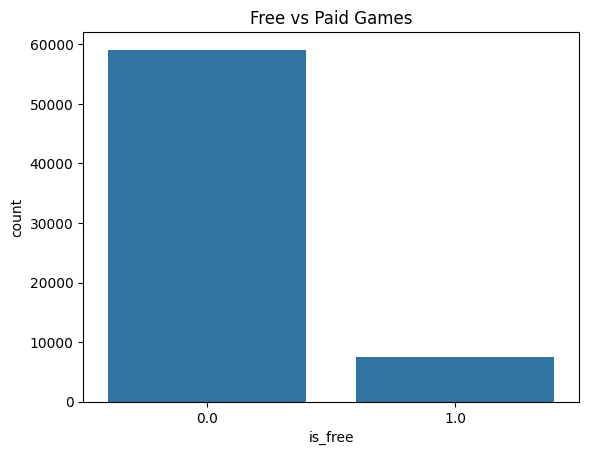

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of Free vs Paid Games
sns.countplot(x='is_free', data=df)
plt.title("Free vs Paid Games")
plt.show()


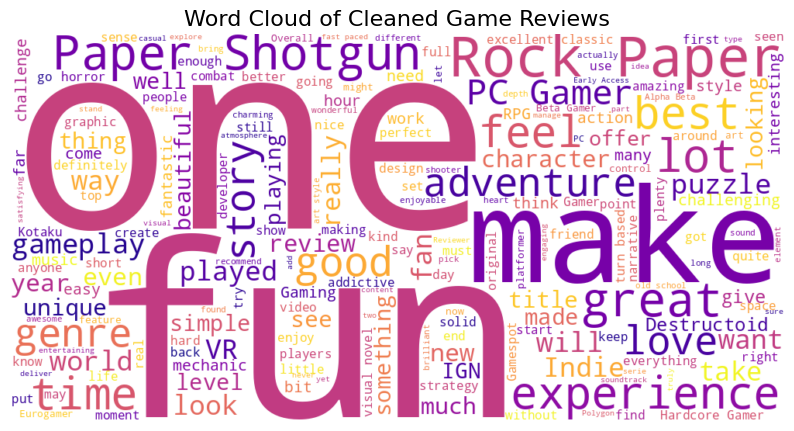

In [17]:
#Combine all cleaned reviews
all_reviews = " ".join(cleaned_data['reviews'].tolist())

#Define custom stopwords
custom_stopwords = STOPWORDS.union({'game', 'games', 'play', 'player', 'steam', 's', 'x', 'D', '_x000D','_','_x000D_'})

# Generate the word cloud
wc = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='plasma',
    stopwords=custom_stopwords
).generate(all_reviews)

# Plot
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Game Reviews', fontsize=16)
plt.show()

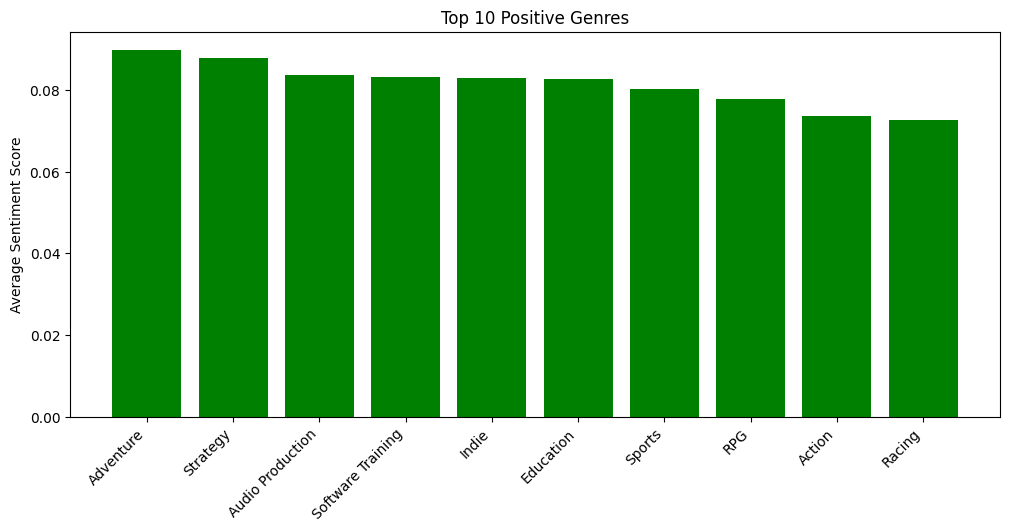

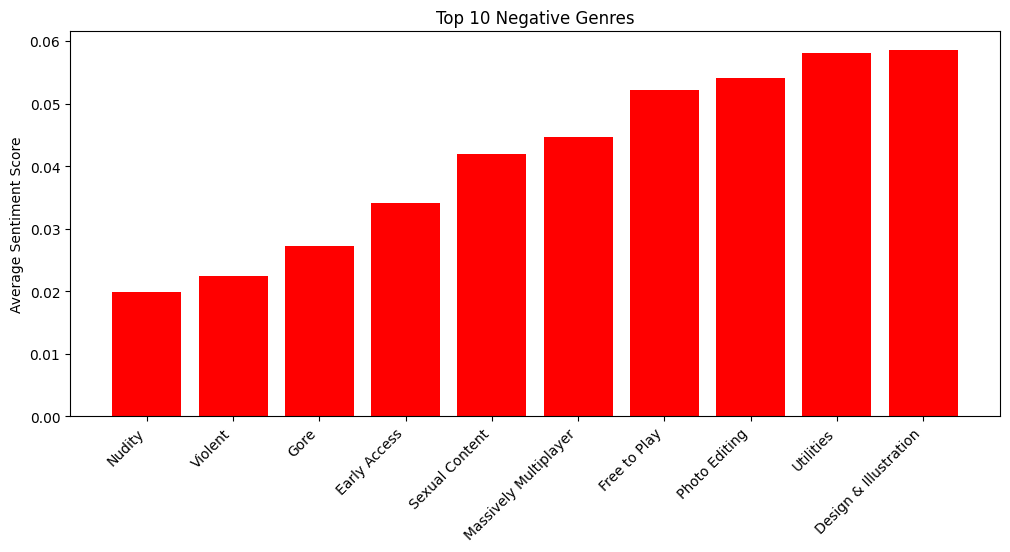

In [18]:
#nltk.download('vader_lexicon')  # uncomment if needed

# Compute average sentiment per genre
sentiment_by_genre = data_exploded.groupby('genres')['sentiment'].mean()

# Optional: remove genres with very few reviews (less than 5)
genre_counts = data_exploded.groupby('genres')['sentiment'].count()
valid_genres = genre_counts[genre_counts >= 5].index
sentiment_by_genre = sentiment_by_genre.loc[valid_genres]

# Sort for plotting
sentiment_by_genre = sentiment_by_genre.sort_values(ascending=False)

# Plot top 10 positive genres
top_positive = sentiment_by_genre.head(10)
plt.figure(figsize=(12,5))
plt.bar(top_positive.index, top_positive.values, color='green')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Sentiment Score')
plt.title('Top 10 Positive Genres')
plt.show()

# Plot top 10 negative genres
top_negative = sentiment_by_genre.nsmallest(10)
plt.figure(figsize=(12,5))
plt.bar(top_negative.index, top_negative.values, color='red')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Sentiment Score')
plt.title('Top 10 Negative Genres')
plt.show()

In [19]:
data_exploded['genres'] = data_exploded['genres'].astype(str).str.replace(r'[\[\]\'"]', '', regex=True).str.strip()
data_exploded['genres'] = data_exploded['genres'].str.replace(r'[\[\]\'"]', '', regex=True).str.strip()
data_exploded['genres'] = data_exploded['genres'].str.replace(r'[\[\]]', '', regex=True)
data_exploded['genres'] = data_exploded['genres'].str.replace(r'\\+', '', regex=True)


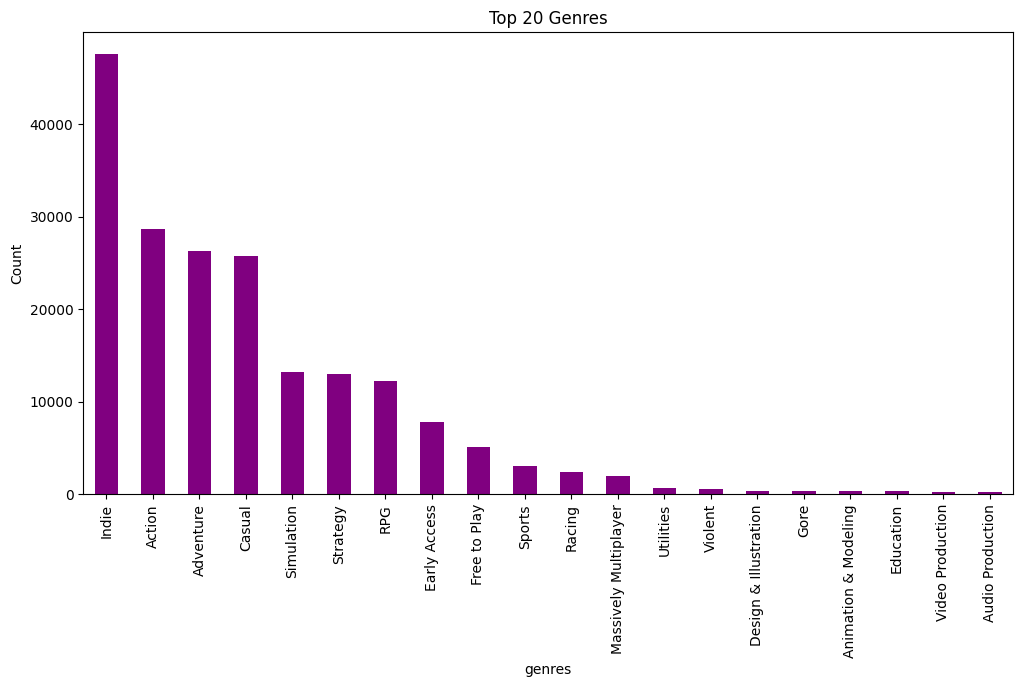

In [20]:
# Fill NaNs and convert to string
df['genres'] = df['genres'].fillna('').astype(str)

# Remove square brackets
#df['genres'] = df['genres'].str.replace(r'[\[\]]', '', regex=True)

# Split multiple genres into lists
#df['genres'] = df['genres'].str.split(r'\||,|/|;')

# Explode so each genre has its own row
#data_exploded = df.explode('genres')

# Strip whitespace and remove empty strings
data_exploded['genres'] = data_exploded['genres'].str.strip()
data_exploded = data_exploded[data_exploded['genres'] != '']

# Plot top 20 genres by count
top_genres = data_exploded['genres'].value_counts().head(20)
top_genres.plot(kind='bar', figsize=(12,6), color='purple')
plt.title("Top 20 Genres")
plt.ylabel("Count")
plt.show()


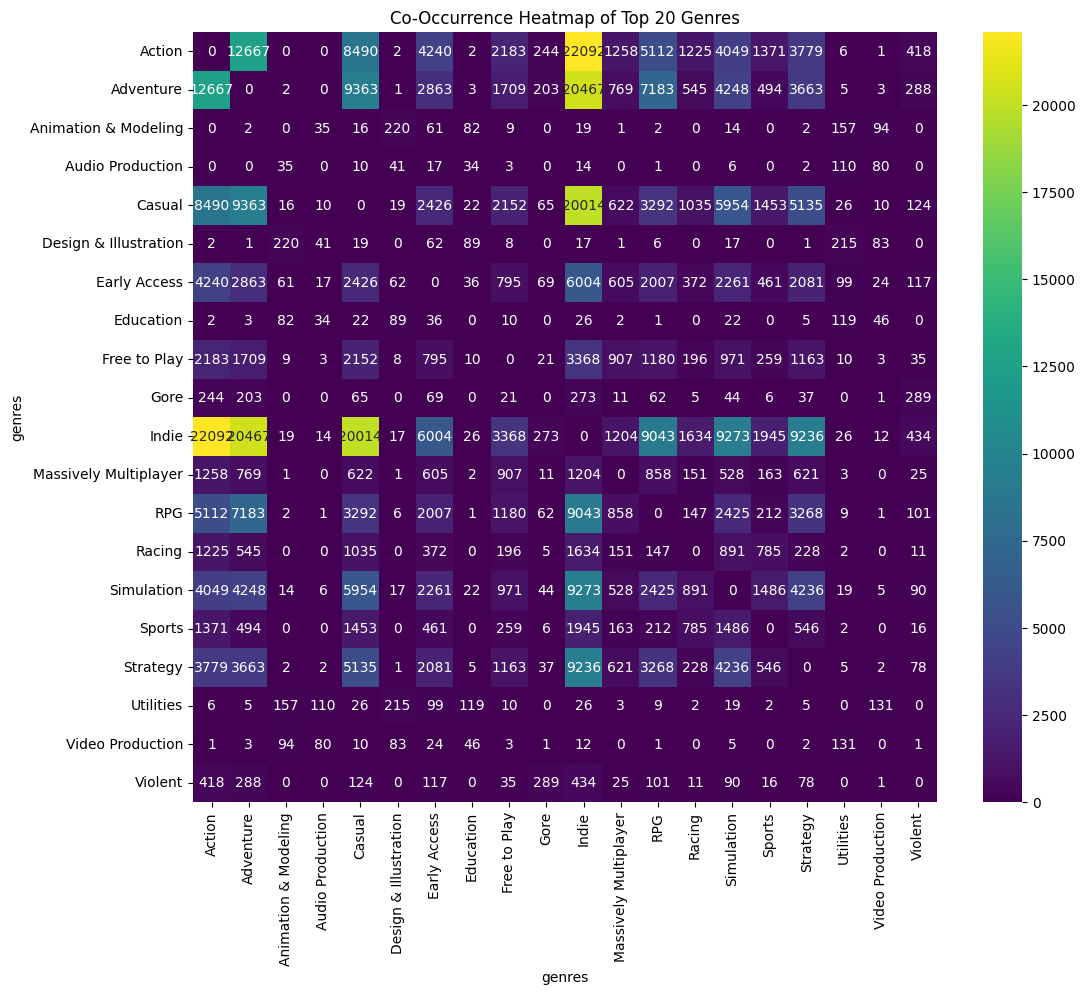

In [21]:
# Pick top N genres by count
top_genres = data_exploded['genres'].value_counts().head(20).index
filtered_data = data_exploded[data_exploded['genres'].isin(top_genres)]

# Create genre co-occurrence matrix for top genres
genre_matrix = pd.crosstab(filtered_data['steam_appid'], filtered_data['genres'])

co_occurrence_top = genre_matrix.T.dot(genre_matrix)
# Set diagonal to zero (optional, removes self-counts)
np.fill_diagonal(co_occurrence_top.values, 0)

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(co_occurrence_top, cmap="viridis", annot=True, fmt="d")
plt.title("Co-Occurrence Heatmap of Top 20 Genres")
plt.show()

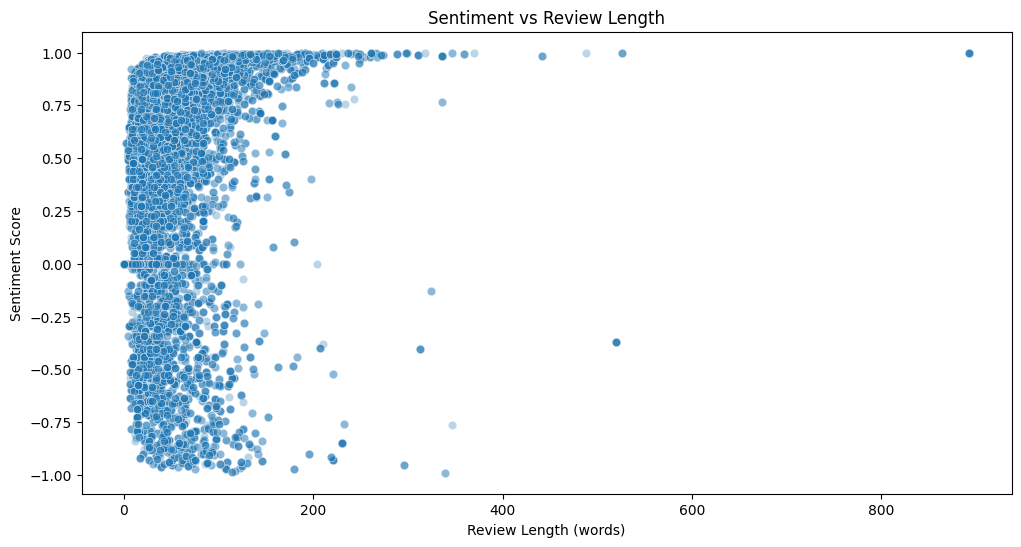

In [22]:
data_exploded['review_len'] = data_exploded['reviews'].str.split().apply(len)
plt.figure(figsize=(12,6))
sns.scatterplot(x='review_len', y='sentiment', data=data_exploded, alpha=0.3)
plt.xlabel("Review Length (words)")
plt.ylabel("Sentiment Score")
plt.title("Sentiment vs Review Length")
plt.show()

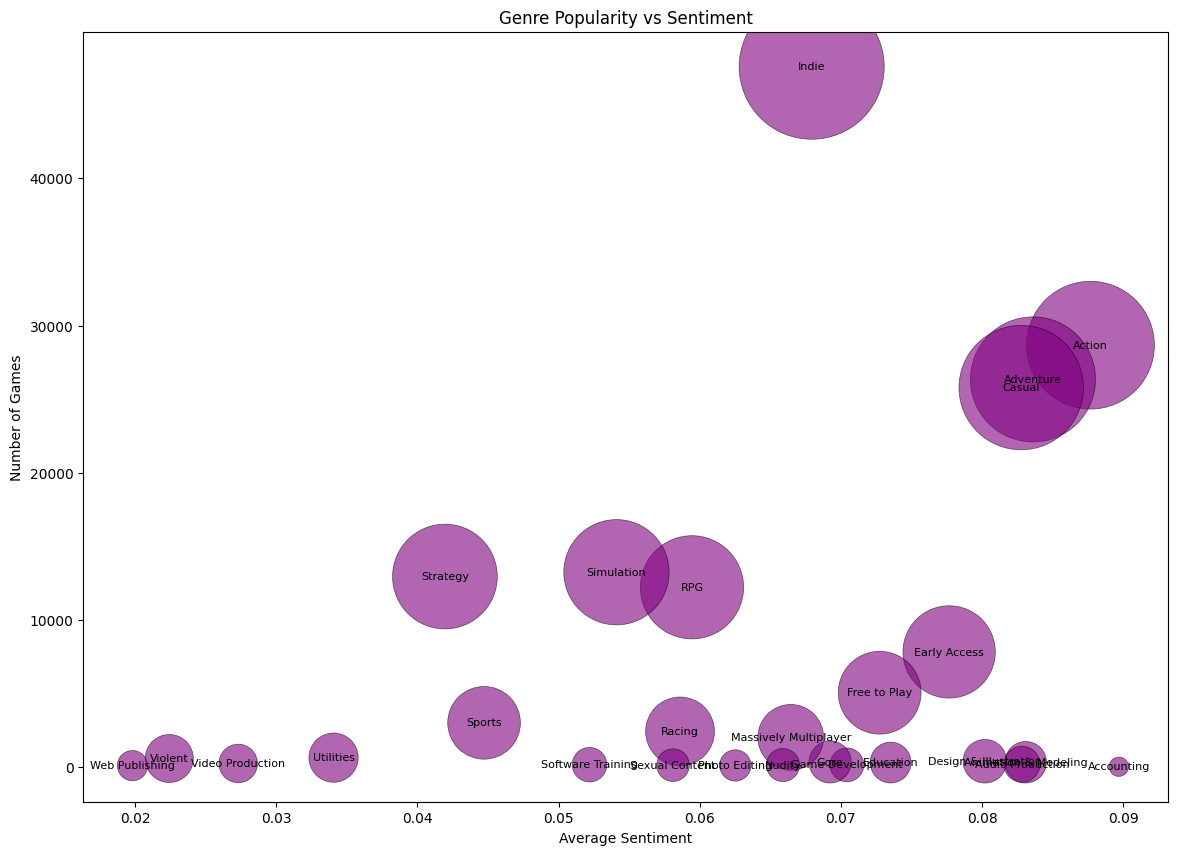

In [103]:
# Align sentiment and counts (assuming you already filtered valid genres)
genre_counts_filtered = genre_counts.loc[valid_genres]

# Bubble size: square root scaling to reduce overlap
bubble_sizes = np.sqrt(genre_counts_filtered.values) * 50  # tweak 50 as needed

plt.figure(figsize=(14,10))
plt.scatter(
    sentiment_by_genre.values,
    genre_counts_filtered.values,
    s=bubble_sizes,
    alpha=0.6,
    color='purple',
    edgecolor='black',   # makes overlapping bubbles distinguishable
    linewidth=0.5
)

# Annotate bubbles with genre labels in black
for i, genre in enumerate(valid_genres):
    plt.text(
        sentiment_by_genre.values[i],
        genre_counts_filtered.values[i],
        genre,
        ha='center',      # horizontal alignment
        va='center',      # vertical alignment
        fontsize=8,
        color='black'     # label text color
    )

plt.xlabel("Average Sentiment")
plt.ylabel("Number of Games")
plt.title("Genre Popularity vs Sentiment")
plt.show()

In [90]:

# Try MultiLabelStratifiedKFold; fall back to KFold
try:
    from iterstrat.ml_stratifiers import MultiLabelStratifiedKFold
    HAS_ITERSTRAT = True
except Exception as e:
    print("iterative-stratification not available; falling back to KFold. Reason:", e)
    HAS_ITERSTRAT = False

# Colab upload helper
try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    IN_COLAB = False

RANDOM_STATE = 44
np.random.seed(RANDOM_STATE)

# Helpers
def safe_eval(obj):
    if isinstance(obj, (dict, list)):
        return obj
    if obj is None or (isinstance(obj, float) and np.isnan(obj)):
        return None
    s = str(obj).strip()
    if not s:
        return None
    try:
        return json.loads(s)
    except Exception:
        pass
    try:
        return ast.literal_eval(s)
    except Exception:
        if "," in s and "[" not in s and "{" not in s:
            return [x.strip() for x in s.split(",") if x.strip()]
    return None

def count_items(field):
    v = safe_eval(field)
    if v is None:
        return 0
    if isinstance(v, dict):
        return len(v)
    if isinstance(v, (list, tuple, set)):
        return len(v)
    return 1 if str(v).strip() else 0

def parse_price(price_overview, price_col, is_free):
    if pd.notna(is_free) and int(is_free) == 1:
        return 0.0
    pov = safe_eval(price_overview)
    if isinstance(pov, dict):
        if "final" in pov and isinstance(pov["final"], (int, float)):
            return float(pov["final"]) / 100.0
        if "price" in pov and isinstance(pov["price"], (int, float)):
            return float(pov["price"])
        if "final_formatted" in pov:
            m = re.findall(r"[\d\.]+", str(pov["final_formatted"]))
            if m:
                return float(m[0])
    if price_col is not None and not (isinstance(price_col, float) and math.isnan(price_col)):
        try:
            return float(price_col)
        except Exception:
            pass
    return np.nan

def platforms_flags(platforms_field):
    win = mac = linux = 0
    p = safe_eval(platforms_field)
    if isinstance(p, dict):
        win = 1 if p.get("windows") else 0
        mac = 1 if p.get("mac") else 0
        linux = 1 if p.get("linux") else 0
    elif isinstance(p, list):
        s = set([str(x).lower() for x in p])
        win = 1 if "windows" in s or "win" in s else 0
        mac = 1 if "mac" in s or "osx" in s else 0
        linux = 1 if "linux" in s else 0
    elif isinstance(p, str):
        s = p.lower()
        win = 1 if ("win" in s or "windows" in s) else 0
        mac = 1 if ("mac" in s or "osx" in s) else 0
        linux = 1 if "linux" in s else 0
    return win, mac, linux

def first_token_popularity(series):
    tokens = []
    for v in series.fillna("").astype(str).tolist():
        tok = v.split(",")[0].strip()
        if tok:
            tokens.append(tok)
    return Counter(tokens)

def languages_count(field):
    v = safe_eval(field)
    if isinstance(v, (list, tuple, set)): return len(v)
    if isinstance(v, str):
        parts = [x.strip() for x in v.split(",") if x.strip()]
        return len(parts)
    return 0

def parse_genres(field):
    v = safe_eval(field)
    if isinstance(v, list):
        vals = []
        for x in v:
            if isinstance(x, dict):
                if "description" in x: vals.append(str(x["description"]).strip())
                elif "name" in x:      vals.append(str(x["name"]).strip())
            else:
                vals.append(str(x).strip())
        return [g for g in vals if g]
    if isinstance(v, dict): return [str(x).strip() for x in v.values() if str(x).strip()]
    if isinstance(v, str):  return [x.strip() for x in v.split(",") if x.strip()]
    return []

def build_features(df):
    dev_pop_map = first_token_popularity(df.get('developers', pd.Series(dtype=str)))
    pub_pop_map = first_token_popularity(df.get('publishers', pd.Series(dtype=str)))
    def first_token(val):
        if pd.isna(val): return ""
        return str(val).split(",")[0].strip()
    feat = pd.DataFrame(index=df.index)
    feat["is_free"] = df.get("is_free", 0).fillna(0).astype(int)
    feat["required_age"] = pd.to_numeric(df.get("required_age", 0), errors="coerce").fillna(0)
    feat["price"] = df.apply(lambda r: parse_price(r.get('price_overview', None),
                                                   r.get('price', None),
                                                   r.get('is_free', 0)), axis=1).fillna(0.0)
    pf = df['platforms'].apply(platforms_flags)
    feat[['win','mac','linux']] = pd.DataFrame(pf.tolist(), index=df.index)
    for col in ['dlc','screenshots','movies','packages','package_groups','demos']:
        feat[f"{col}_count"] = df[col].apply(count_items) if col in df.columns else 0
    feat['supported_languages_count'] = df['supported_languages'].apply(languages_count) if 'supported_languages' in df.columns else 0
    feat['developer_first'] = df.get('developers', "").apply(first_token)
    feat['publisher_first'] = df.get('publishers', "").apply(first_token)
    feat['developer_popularity'] = feat['developer_first'].map(dev_pop_map).fillna(0).astype(int)
    feat['publisher_popularity'] = feat['publisher_first'].map(pub_pop_map).fillna(0).astype(int)
    return feat.drop(columns=['developer_first','publisher_first']).fillna(0)

# Model wrappers & evaluation
def get_models():
    models = {}

    # Logistic Regression (baseline)
    models["logreg"] = OneVsRestClassifier(
        LogisticRegression(
            solver="liblinear",
            max_iter=1000,
            class_weight="balanced",
            random_state=RANDOM_STATE
        )
    )

    # Random Forest (supports predict_proba)
    models["rf"] = OneVsRestClassifier(
        RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=RANDOM_STATE,
            class_weight=None
        )
    )

    # Linear SVC
    models["linsvc"] = OneVsRestClassifier(
        LinearSVC(
            C=1.0,
            class_weight="balanced",
            max_iter=5000,
            random_state=RANDOM_STATE
        )
    )
    return models

def tune_and_predict(estimator, X_te, Y_te):
    chosen_threshold = 0.5
    Y_pred = None

    proba = None
    try:
        proba = estimator.predict_proba(X_te)
    except Exception:
        proba = None

    if proba is not None:
        thresholds = np.arange(0.30, 0.71, 0.05)
        best_thr, best_f1 = 0.50, -1
        for thr in thresholds:
            Y_hat = (proba >= thr).astype(int)
            f1m = f1_score(Y_te, Y_hat, average="micro", zero_division=0)
            if f1m > best_f1:
                best_f1, best_thr = f1m, thr
        chosen_threshold = best_thr
        Y_pred = (proba >= chosen_threshold).astype(int)
        return Y_pred, chosen_threshold

    try:
        scores = estimator.decision_function(X_te)
        # Candidate thresholds as percentiles of all scores:
        flat = scores.ravel()
        # Guard for degenerate distributions:
        if np.all(flat == flat[0]):
            Y_pred = (scores >= 0.0).astype(int)
            return Y_pred, 0.0
        perc = np.linspace(10, 90, 9)
        candidates = np.percentile(flat, perc)

        candidates = np.unique(np.append(candidates, 0.0))
        best_thr, best_f1 = 0.0, -1
        for thr in candidates:
            Y_hat = (scores >= thr).astype(int)
            f1m = f1_score(Y_te, Y_hat, average="micro", zero_division=0)
            if f1m > best_f1:
                best_f1, best_thr = f1m, thr
        chosen_threshold = float(best_thr)
        Y_pred = (scores >= chosen_threshold).astype(int)
        return Y_pred, chosen_threshold
    except Exception:
        return estimator.predict(X_te), 0.0

def compute_label_metrics(Y_te, Y_pred, label_names, fold):
    pr, rc, f1, sup = precision_recall_fscore_support(Y_te, Y_pred, average=None, zero_division=0)
    rows = []
    for i, lbl in enumerate(label_names):
        y_true_col, y_pred_col = Y_te[:, i], Y_pred[:, i]
        tp = int(((y_true_col == 1) & (y_pred_col == 1)).sum())
        fp = int(((y_true_col == 0) & (y_pred_col == 1)).sum())
        fn = int(((y_true_col == 1) & (y_pred_col == 0)).sum())
        tn = int(((y_true_col == 0) & (y_pred_col == 0)).sum())
        rows.append({
            "fold": fold, "label": lbl,
            "precision": pr[i], "recall": rc[i], "f1": f1[i], "support": int(sup[i]),
            "TP": tp, "FP": fp, "FN": fn, "TN": tn,
        })
    return rows

# Main runner
def run_pipeline(input_xlsx, out_dir="team44_cv10", sample_cap=600):
    out_path = Path(out_dir); out_path.mkdir(parents=True, exist_ok=True)
    df = pd.read_excel(input_xlsx)
    orig_len = len(df)
    if len(df) > sample_cap:
        df = df.sample(n=sample_cap, random_state=RANDOM_STATE).reset_index(drop=True)


    genres_list = df['genres'].apply(parse_genres)
    all_genres = [g for lst in genres_list for g in lst]
    top_genres = pd.Series(all_genres).value_counts().head(15)
    price_vals = df.apply(lambda r: parse_price(r.get('price_overview', None),
                                                r.get('price', None),
                                                r.get('is_free', 0)), axis=1)
    platform_flags = df['platforms'].apply(platforms_flags)
    platform_df = pd.DataFrame(platform_flags.tolist(), columns=['win','mac','linux'])

    pd.DataFrame({'column': df.columns,
                  'n_non_null': df.notnull().sum().values,
                  'n_unique': df.nunique().values,
                  'dtype': df.dtypes.values.astype(str)}).to_csv(out_path / "eda_column_summary.csv", index=False)

    # Features & Targets
    feat = build_features(df)
    y_list = genres_list.tolist()
    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(y_list)
    label_names = mlb.classes_.tolist()

    # Scale numeric only; pass binary flags
    binary_cols = [c for c in feat.columns if set(pd.Series(feat[c].unique()).dropna().unique()) <= {0,1}]
    num_cols = [c for c in feat.columns if c not in binary_cols]
    preprocess = ColumnTransformer(
        transformers=[("scale", StandardScaler(with_mean=True, with_std=True), num_cols),
                      ("pass", "passthrough", binary_cols)],
        remainder="drop"
    )
    X_all = preprocess.fit_transform(feat)
    feature_names_transformed = num_cols + binary_cols

    # CV Splitter (10-fold)
    if HAS_ITERSTRAT:
        cv = MultiLabelStratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
        cv_note = "Used MultiLabelStratifiedKFold (iterstrat)."
    else:
        cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
        cv_note = "iterstrat not available; fell back to KFold (not stratified by labels)."

    # Train & evaluate models
    models = get_models()
    model_scores = {}
    cv_metric_traces = {}  # for comparison plot

    for model_key, estimator in models.items():
        print(f"\n=== Training {model_key} ===")
        cv_rows, label_rows_all = [], []
        coef_folds = []      # for linear models (LR, LinearSVC)
        rf_imp_folds = []    # for RF

        for fold, (tr, te) in enumerate(cv.split(X_all, Y)):
            X_tr, X_te = X_all[tr], X_all[te]
            Y_tr, Y_te = Y[tr], Y[te]
            estimator.fit(X_tr, Y_tr)

            Y_pred, chosen_threshold = tune_and_predict(estimator, X_te, Y_te)

            cv_rows.append({
                "fold": fold,
                "hamming_loss": hamming_loss(Y_te, Y_pred),
                "micro_f1": f1_score(Y_te, Y_pred, average="micro", zero_division=0),
                "macro_f1": f1_score(Y_te, Y_pred, average="macro", zero_division=0),
                "weighted_f1": f1_score(Y_te, Y_pred, average="weighted", zero_division=0),
                "micro_precision": precision_score(Y_te, Y_pred, average="micro", zero_division=0),
                "micro_recall": recall_score(Y_te, Y_pred, average="micro", zero_division=0),
                "chosen_threshold": chosen_threshold,
                "n_samples": Y_te.shape[0],
            })

            label_rows_all.extend(compute_label_metrics(Y_te, Y_pred, label_names, fold))

            # Collect importances/coeffs per label if available
            try:
                # Linear models (LR, LinearSVC)
                if hasattr(estimator, "estimators_") and hasattr(estimator.estimators_[0], "coef_"):
                    coefs = np.vstack([clf.coef_.ravel() for clf in estimator.estimators_])
                    coef_folds.append(coefs)
            except Exception:
                pass
            try:
                # RF impurity importances per label (averaged across trees already)
                if hasattr(estimator, "estimators_") and hasattr(estimator.estimators_[0], "feature_importances_"):
                    imps = np.vstack([clf.feature_importances_.ravel() for clf in estimator.estimators_])
                    rf_imp_folds.append(imps)
            except Exception:
                pass

        # Save metrics for this model
        mdl_out = Path(out_dir)
        fold_df = pd.DataFrame(cv_rows)
        fold_df.to_csv(mdl_out / f"cv_folds_summary_{model_key}.csv", index=False)
        cv_metric_traces[model_key] = fold_df["micro_f1"].tolist()

        def avg_std(series): return f"{series.mean():.4f} ± {series.std():.4f}"
        avg_df = pd.DataFrame({
            "metric": ["hamming_loss","micro_f1","macro_f1","weighted_f1","micro_precision","micro_recall","threshold_mean"],
            "mean": [fold_df[c].mean() for c in ["hamming_loss","micro_f1","macro_f1","weighted_f1","micro_precision","micro_recall"]] + [fold_df["chosen_threshold"].mean()],
            "std":  [fold_df[c].std()  for c in ["hamming_loss","micro_f1","macro_f1","weighted_f1","micro_precision","micro_recall"]]  + [fold_df["chosen_threshold"].std()],
            "mean±std": [
                avg_std(fold_df["hamming_loss"]), avg_std(fold_df["micro_f1"]), avg_std(fold_df["macro_f1"]),
                avg_std(fold_df["weighted_f1"]), avg_std(fold_df["micro_precision"]), avg_std(fold_df["micro_recall"]),
                avg_std(fold_df["chosen_threshold"]),
            ],
        })
        avg_df.to_csv(mdl_out / f"cv_avg_metrics_{model_key}.csv", index=False)

        lab_all = pd.DataFrame(label_rows_all)
        lab_all.groupby("label", as_index=False)[["precision","recall","f1","support","TP","FP","FN","TN"]].mean()\
               .to_csv(mdl_out / f"label_metrics_cv_avg_{model_key}.csv", index=False)

        # Save importances
        if model_key in ["logreg", "linsvc"] and len(coef_folds) > 0:
            coefs_stack = np.stack(coef_folds, axis=0)  # (folds, n_labels, n_features)
            coefs_mean = coefs_stack.mean(axis=0)
            abs_coefs = np.abs(coefs_mean)
            rows = []
            for li, lbl in enumerate(label_names):
                idx = np.argsort(-abs_coefs[li])[:10]
                for rank, fi in enumerate(idx, start=1):
                    rows.append({"label": lbl, "rank": rank, "feature": feature_names_transformed[fi],
                                 "coef": coefs_mean[li, fi], "|coef|": abs_coefs[li, fi]})
            pd.DataFrame(rows).to_csv(mdl_out / f"{model_key}_coeff_top10_by_label.csv", index=False)
            pd.DataFrame({
                "feature": feature_names_transformed,
                "mean_abs_coef_across_labels": abs_coefs.mean(axis=0)
            }).sort_values("mean_abs_coef_across_labels", ascending=False)\
             .to_csv(mdl_out / f"{model_key}_global_importance.csv", index=False)

        if model_key == "rf" and len(rf_imp_folds) > 0:
            imps_stack = np.stack(rf_imp_folds, axis=0)  # (folds, n_labels, n_features)
            imps_mean = imps_stack.mean(axis=0)
            rows = []
            for li, lbl in enumerate(label_names):
                idx = np.argsort(-imps_mean[li])[:10]
                for rank, fi in enumerate(idx, start=1):
                    rows.append({"label": lbl, "rank": rank, "feature": feature_names_transformed[fi],
                                 "importance": imps_mean[li, fi]})
            pd.DataFrame(rows).to_csv(mdl_out / "rf_impurity_top10_by_label.csv", index=False)
            pd.DataFrame({
                "feature": feature_names_transformed,
                "mean_impurity_importance_across_labels": imps_mean.mean(axis=0)
            }).sort_values("mean_impurity_importance_across_labels", ascending=False)\
             .to_csv(mdl_out / "rf_impurity_global_importance.csv", index=False)

        # Keep scores for comparison chart
        model_scores[model_key] = (fold_df["micro_f1"].mean(), fold_df["micro_f1"].std())

    # Comparison figure (3 models)
    names = ["logreg", "rf", "linsvc"]
    means = [model_scores[k][0] for k in names]
    stds  = [model_scores[k][1] for k in names]
    plt.figure()
    xs = np.arange(len(names))
    plt.bar(xs, means, yerr=stds, capsize=5)
    plt.xticks(xs, names)
    plt.ylabel("Micro-F1 (mean ± std)")
    plt.title("Model Comparison (10-fold CV)")
    plt.tight_layout()
    plt.savefig(out_path / "model_comparison_cv10.png");
    names_for_box = [k for k in ["logreg", "rf", "linsvc"] if k in cv_metric_traces]
    data_for_box  = [cv_metric_traces[k] for k in names_for_box]

    plt.figure(figsize=(6,4))
    plt.boxplot(data_for_box, labels=names_for_box, patch_artist=True)
    plt.title("10-fold Cross Validation")
    plt.ylabel("Micro-F1")
    plt.tight_layout()
    plt.show()
    plt.savefig(out_path / "cv_boxplot_micro_f1.png")
    plt.close()



iterative-stratification not available; falling back to KFold. Reason: cannot import name 'MultiLabelStratifiedKFold' from 'iterstrat.ml_stratifiers' (/usr/local/lib/python3.12/dist-packages/iterstrat/ml_stratifiers.py)



=== Training logreg ===


/usr/local/lib/python3.12/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(



=== Training rf ===


/usr/local/lib/python3.12/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(



=== Training linsvc ===


/usr/local/lib/python3.12/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(
/tmp/ipython-input-3414898175.py:414: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=names_for_box, patch_artist=True)


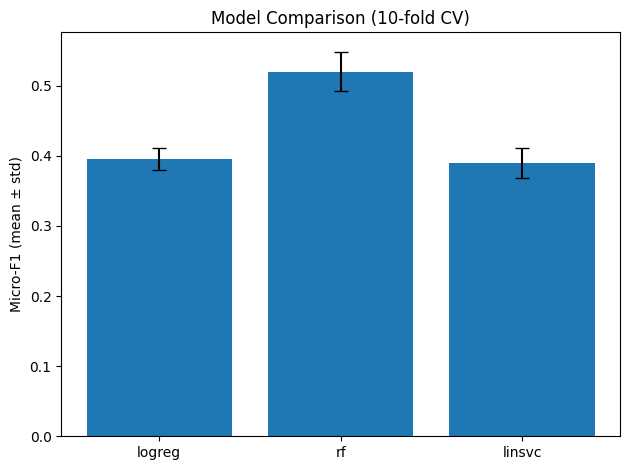

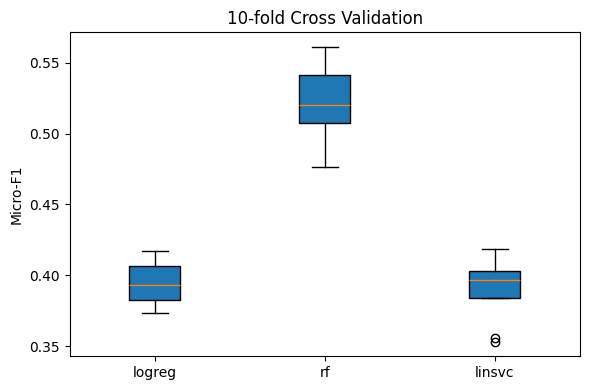

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [91]:
# Upload, Run, and Download ZIP
default_name = "steam_app_data_clean.xlsx"
if not Path(default_name).exists() and IN_COLAB:
    up = files.upload()
    if len(up) > 0:
        default_name = list(up.keys())[0]

#OUT_DIR = run_pipeline(default_name, out_dir="team44_cv10", sample_cap=600)
_ = run_pipeline(default_name, out_dir="team44_cv10", sample_cap=600)  # ignore return
out_dir_path = Path("team44_cv10")

zip_path = Path("/content/team44_cv10.zip")
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    for p in out_dir_path.rglob("*"):
        zf.write(p, arcname=str(Path("team44_cv10") / p.relative_to(out_dir_path)))

if IN_COLAB:
    from google.colab import files
    files.download(str(zip_path))
